In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import albumentations as A
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
data_dir = './drive/MyDrive/data1'
print(os.listdir(data_dir))

['joy1', 'calmness1', 'anger1', 'sadness1']


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_size = 128
batch_size = 128
num_channels = 3
latent_size = 100
embed_size = 100
features_g = 64
features_d = 32
num_epochs = 300
lr = 1e-3
num_classes = 4
fixed_latent = torch.randn(batch_size, latent_size, 1, 1).to(device)
criterion = nn.BCELoss().to(device)
fixed_labels = torch.LongTensor(batch_size).random_(0,4).to(device)

In [ ]:
transforms = tt.Compose([
          #tt.RandomAutocontrast(),
          #tt.Grayscale(),
          tt.Resize(img_size),
          tt.CenterCrop(img_size),
          #tt.RandomHorizontalFlip(),
          #tt.RandomRotation(45),
          tt.ToTensor(),
          tt.Normalize((0.5, ), (0.5, ))
])

In [ ]:
train_ds = ImageFolder(data_dir, transforms)
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)

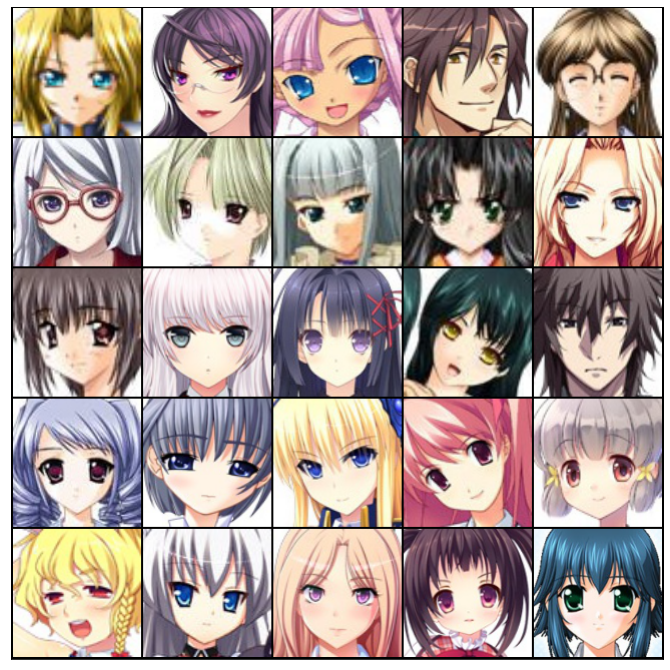

In [ ]:
def show_batch(dl):
  for images, _ in dl:
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images[:25], normalize=True, nrow=5).permute(1, 2, 0))
    break

show_batch(train_dl)

In [ ]:
class Generator(nn.Module):
  def __init__(self, features_g, latent_size, num_channels, embed_size, num_classes):
    super(Generator, self).__init__()
    self.embed = nn.Embedding(num_classes, embed_size)
    self.net = nn.Sequential(
        self.deConvBlock(latent_size, features_g*16, 4, 1, 0),
        self.deConvBlock(features_g*16, features_g*8, 4, 2, 1),
        self.deConvBlock(features_g*8, features_g*4, 4, 2, 1),
        self.deConvBlock(features_g*4, features_g*2, 4, 2, 1),
        self.deConvBlock(features_g*2, features_g, 4, 2, 1),
        nn.ConvTranspose2d(features_g, num_channels, 4, 2, 1),
        nn.Tanh()
    )

  def deConvBlock(self, in_channels, out_channels, kernel_size, stride, padding, bias=False):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2, inplace=True),
        #nn.ReLU(inplace=True),
    )

  def forward(self, x):
    return self.net(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, features_d, num_channels, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.embed = nn.Embedding(num_classes, img_size*img_size)
        self.img_size = img_size
        self.net = nn.Sequential(
            nn.Conv2d(num_channels, features_d, 4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(features_d),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features_d, features_d* 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features_d * 2, features_d * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features_d * 4, features_d * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_d * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features_d * 8, features_d * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_d * 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features_d * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
      return self.net(x)

In [ ]:
def initialize_weights(model):
  for module in model.modules():
    if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
      nn.init.normal_(module.weight.data, 0.0, 0.02)
    elif isinstance(module, nn.BatchNorm2d):
      nn.init.normal_(module.weight.data, 1.0, 0.02)
      nn.init.constant_(module.bias.data, 0)

In [ ]:
netG = Generator(features_g, latent_size, num_channels, embed_size, num_classes).to(device)
netD = Discriminator(features_d, num_channels, num_classes, img_size).to(device)
initialize_weights(netG)
initialize_weights(netD)


optimG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optimD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
Gparams = sum(p.numel() for p in netG.parameters() if p.requires_grad)
Dparams = sum(p.numel() for p in netD.parameters() if p.requires_grad)
Gparams, Dparams

(14425363, 2863040)

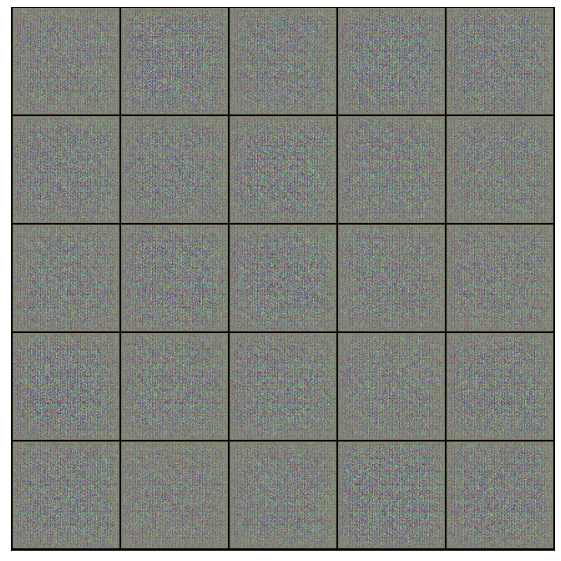

In [ ]:
sample_dir = 'generated2'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent, show=True):
  fake_images = netG(latent)[:25]
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  grid = make_grid(fake_images.cpu().detach(), nrow=5, normalize=True)
  save_image(grid, os.path.join(sample_dir, fake_fname))
  if show:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(grid.permute(1, 2, 0))

save_samples(0, fixed_latent)

In [ ]:
losses_g, losses_d = [], [] 
counter = 0
netD.train()
netG.train()
for epoch in range(num_epochs):
  for batch_idx, (images, labels) in enumerate(tqdm(train_dl)):
    # training discriminator
    netD.zero_grad()
    current_batch_size = images.shape[0]
    real_targets = (torch.ones(current_batch_size, 1) - torch.rand(current_batch_size, 1) * 0.2).to(device)
    fake_targets = (torch.zeros(current_batch_size, 1) + torch.rand(current_batch_size, 1) * 0.2).to(device)
    
    images = images.to(device)
    labels = labels.to(device)
    real_preds = netD(images)
    disc_real_loss = criterion(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    noise = torch.randn(current_batch_size, latent_size, 1, 1).to(device)
    fake_images = netG(noise)
    fake_preds = netD(fake_images.detach())
    disc_fake_loss = criterion(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    #disc_loss = torch.log(disc_real_loss) + torch.log(disc_fake_loss)
    disc_loss = disc_real_loss + disc_fake_loss
    disc_loss.backward()
    optimD.step()

    # training generator
    netG.zero_grad()
    
    upd_fake_preds = netD(fake_images)
    #gen_loss = torch.log(criterion(upd_fake_preds, real_targets))
    gen_loss = criterion(upd_fake_preds, real_targets)
    upd_fake_score = torch.mean(upd_fake_preds).item()

    gen_loss.backward()
    optimG.step()

    losses_d.append(disc_loss)
    losses_g.append(gen_loss)
    counter += 1

  print('Epoch [{}/{}], Loss_D: {:.4f}, Loss_G: {:.4f}, D(x): {:.4f}, D(G(z)): {:.4f}/{:.4f}'.format(
      epoch+1, num_epochs, disc_loss, gen_loss, real_score, fake_score, upd_fake_score
  ))
  #with torch.no_grad():
    #save_samples(epoch+1, fixed_latent, show=False)


In [ ]:
import shutil
shutil.make_archive('2005_data_g64d32lr1e-3_conditional', 'zip', './generated2')

'/content/2005_data_g64d32lr1e-3_conditional.zip'

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
#ax.set_xticks(["Количество итераций"]); ax.set_yticks(["Значение ошибки"])
ax.plot(losses_d)
ax.plot(losses_g)